  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.7/961.7 kB 6.1 MB/s eta 0:00:00
Air Quality Interpolation & Prediction System
Step 1: Generating synthetic air quality data...
Generated 200 data points

Step 2: Preparing features for machine learning...
Feature matrix shape: (200, 11)

Step 3: Training prediction models...
Training Random Forest...
Training Neural Network...

Model Performance:
------------------------------
Random Forest - RMSE: 8.52, R²: 0.923
Neural Network - RMSE: 14.09, R²: 0.791

Step 4: Creating prediction grid...
Created grid with 14042 points

Step 5: Performing spatial interpolation...
Performing Kriging interpolation...
Kriging interpolation completed

Step 6: Generating ML predictions for grid...
Generating predictions for new locations...

Step 7: Creating visualizations...


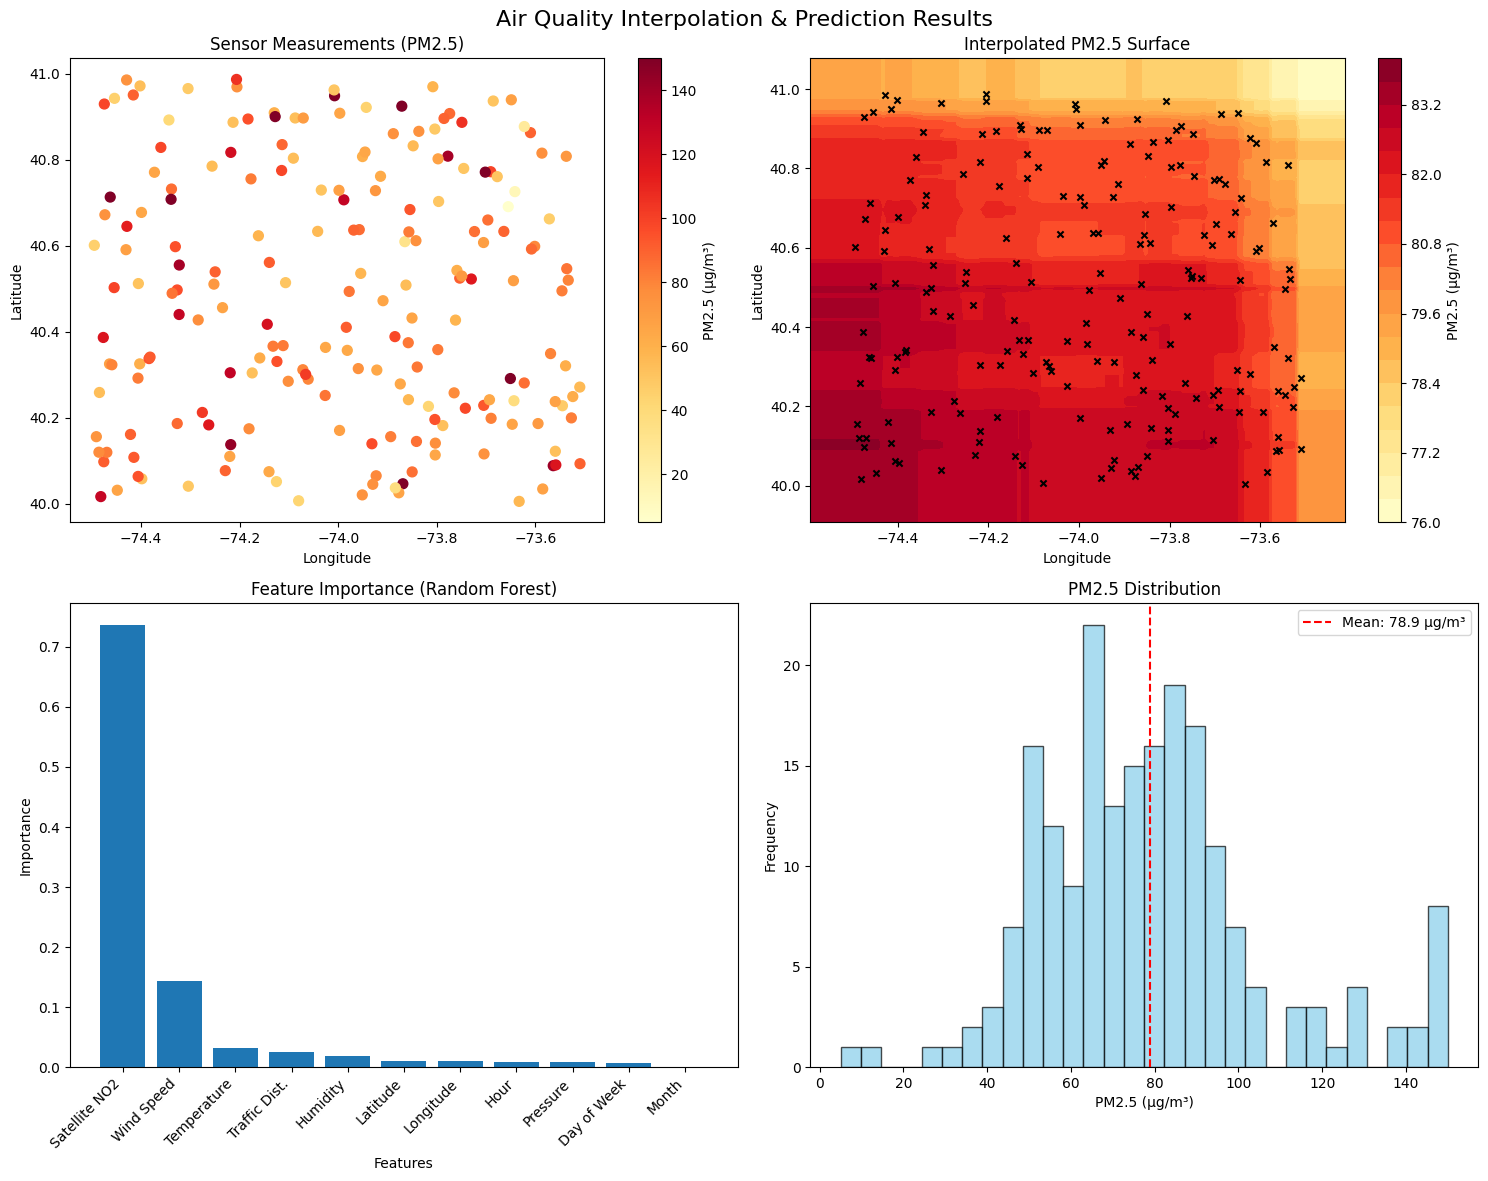

Creating interactive map...
Interactive map saved as 'air_quality_map.html'

Summary Statistics:
Study area: 40.006° to 40.987° N
           -74.495° to -73.509° E
PM2.5 range: 5.0 - 150.0 μg/m³
Average PM2.5: 78.9 μg/m³
Prediction grid: 14042 points
Locations exceeding WHO guideline (15 μg/m³): 198/200 (99.0%)


In [1]:
# Air Quality Interpolation & Prediction System
# Estimate air pollution in grids without sensors using satellite & meteorological data
# SDG 3 - Health

# Install required packages
!pip install ee tensorflow scikit-learn pykrige folium -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

# Spatial Analysis
from pykrige.ok import OrdinaryKriging
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata

# Visualization
import folium
from folium import plugins

print("Air Quality Interpolation & Prediction System")
print("=" * 50)

class AirQualityPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.models = {}
        self.grid_size = 0.01  # Grid resolution in degrees

    def generate_synthetic_data(self, n_points=200):
        """Generate synthetic air quality data for demonstration"""
        np.random.seed(42)

        # Define study area (example coordinates)
        lat_min, lat_max = 40.0, 41.0
        lon_min, lon_max = -74.5, -73.5

        # Generate random sensor locations
        latitudes = np.random.uniform(lat_min, lat_max, n_points)
        longitudes = np.random.uniform(lon_min, lon_max, n_points)

        # Simulate meteorological data
        temperature = np.random.normal(20, 8, n_points)  # Celsius
        humidity = np.random.uniform(30, 90, n_points)   # Percentage
        wind_speed = np.random.exponential(5, n_points)  # m/s
        pressure = np.random.normal(1013, 15, n_points)  # hPa

        # Simulate traffic proximity (distance to major roads)
        traffic_distance = np.random.exponential(2000, n_points)  # meters

        # Simulate satellite data (NO2 column density)
        satellite_no2 = np.random.lognormal(2, 0.8, n_points)

        # Calculate PM2.5 using synthetic relationships
        pm25 = (
            30 +
            temperature * 0.5 +
            humidity * 0.2 +
            wind_speed * (-2) +
            (pressure - 1013) * 0.1 +
            np.exp(-traffic_distance / 1000) * 20 +
            satellite_no2 * 3 +
            np.random.normal(0, 5, n_points)
        )

        # Ensure realistic PM2.5 values
        pm25 = np.clip(pm25, 5, 150)

        data = pd.DataFrame({
            'latitude': latitudes,
            'longitude': longitudes,
            'pm25': pm25,
            'temperature': temperature,
            'humidity': humidity,
            'wind_speed': wind_speed,
            'pressure': pressure,
            'traffic_distance': traffic_distance,
            'satellite_no2': satellite_no2,
            'timestamp': pd.date_range('2024-01-01', periods=n_points, freq='H')
        })

        return data

    def prepare_features(self, data):
        """Prepare features for machine learning"""
        features = [
            'latitude', 'longitude', 'temperature', 'humidity',
            'wind_speed', 'pressure', 'traffic_distance', 'satellite_no2'
        ]

        # Add temporal features
        data['hour'] = data['timestamp'].dt.hour
        data['day_of_week'] = data['timestamp'].dt.dayofweek
        data['month'] = data['timestamp'].dt.month

        features.extend(['hour', 'day_of_week', 'month'])

        return data[features], data['pm25']

    def train_models(self, X, y):
        """Train multiple prediction models"""
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Random Forest Model
        print("Training Random Forest...")
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        self.models['random_forest'] = rf_model

        # Deep Learning Model
        print("Training Neural Network...")
        nn_model = keras.Sequential([
            keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(1)
        ])

        nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        nn_model.fit(
            X_train_scaled, y_train,
            validation_split=0.2,
            epochs=50,
            batch_size=32,
            verbose=0
        )

        nn_pred = nn_model.predict(X_test_scaled, verbose=0).flatten()
        self.models['neural_network'] = nn_model

        # Evaluate models
        print("\nModel Performance:")
        print("-" * 30)

        rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
        rf_r2 = r2_score(y_test, rf_pred)
        print(f"Random Forest - RMSE: {rf_rmse:.2f}, R²: {rf_r2:.3f}")

        nn_rmse = np.sqrt(mean_squared_error(y_test, nn_pred))
        nn_r2 = r2_score(y_test, nn_pred)
        print(f"Neural Network - RMSE: {nn_rmse:.2f}, R²: {nn_r2:.3f}")

        return X_test, y_test, rf_pred, nn_pred

    def kriging_interpolation(self, data, grid_points):
        """Perform Ordinary Kriging interpolation"""
        print("Performing Kriging interpolation...")

        # Extract coordinates and PM2.5 values
        coords = data[['longitude', 'latitude']].values
        values = data['pm25'].values

        # Create Kriging model
        OK = OrdinaryKriging(
            coords[:, 0], coords[:, 1], values,
            variogram_model='spherical',
            verbose=False,
            enable_plotting=False
        )

        # Interpolate
        grid_lons = grid_points[:, 0]
        grid_lats = grid_points[:, 1]

        z, ss = OK.execute('points', grid_lons, grid_lats)

        return z, ss

    def create_prediction_grid(self, data, resolution=0.01):
        """Create prediction grid for spatial interpolation"""
        lat_min, lat_max = data['latitude'].min(), data['latitude'].max()
        lon_min, lon_max = data['longitude'].min(), data['longitude'].max()

        # Expand bounds slightly
        lat_margin = (lat_max - lat_min) * 0.1
        lon_margin = (lon_max - lon_min) * 0.1

        lats = np.arange(lat_min - lat_margin, lat_max + lat_margin, resolution)
        lons = np.arange(lon_min - lon_margin, lon_max + lon_margin, resolution)

        lon_grid, lat_grid = np.meshgrid(lons, lats)
        grid_points = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])

        return grid_points, lon_grid, lat_grid

    def visualize_results(self, data, grid_points, predictions, lon_grid, lat_grid):
        """Create visualizations of results"""

        # Reshape predictions for plotting
        pred_grid = predictions.reshape(lon_grid.shape)

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Air Quality Interpolation & Prediction Results', fontsize=16)

        # 1. Original sensor data
        ax1 = axes[0, 0]
        scatter = ax1.scatter(
            data['longitude'], data['latitude'],
            c=data['pm25'], cmap='YlOrRd', s=50
        )
        ax1.set_title('Sensor Measurements (PM2.5)')
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        plt.colorbar(scatter, ax=ax1, label='PM2.5 (μg/m³)')

        # 2. Interpolated surface
        ax2 = axes[0, 1]
        im = ax2.contourf(lon_grid, lat_grid, pred_grid, levels=20, cmap='YlOrRd')
        ax2.scatter(data['longitude'], data['latitude'], c='black', s=20, marker='x')
        ax2.set_title('Interpolated PM2.5 Surface')
        ax2.set_xlabel('Longitude')
        ax2.set_ylabel('Latitude')
        plt.colorbar(im, ax=ax2, label='PM2.5 (μg/m³)')

        # 3. Feature importance (Random Forest)
        ax3 = axes[1, 0]
        if 'random_forest' in self.models:
            feature_names = [
                'Latitude', 'Longitude', 'Temperature', 'Humidity',
                'Wind Speed', 'Pressure', 'Traffic Dist.', 'Satellite NO2',
                'Hour', 'Day of Week', 'Month'
            ]
            importances = self.models['random_forest'].feature_importances_
            indices = np.argsort(importances)[::-1]

            ax3.bar(range(len(importances)), importances[indices])
            ax3.set_title('Feature Importance (Random Forest)')
            ax3.set_xlabel('Features')
            ax3.set_ylabel('Importance')
            ax3.set_xticks(range(len(importances)))
            ax3.set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')

        # 4. PM2.5 distribution
        ax4 = axes[1, 1]
        ax4.hist(data['pm25'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax4.axvline(data['pm25'].mean(), color='red', linestyle='--',
                   label=f'Mean: {data["pm25"].mean():.1f} μg/m³')
        ax4.set_title('PM2.5 Distribution')
        ax4.set_xlabel('PM2.5 (μg/m³)')
        ax4.set_ylabel('Frequency')
        ax4.legend()

        plt.tight_layout()
        plt.show()

        # Create interactive map
        self.create_interactive_map(data, grid_points, predictions, lon_grid, lat_grid)

    def create_interactive_map(self, data, grid_points, predictions, lon_grid, lat_grid):
        """Create interactive Folium map"""
        print("Creating interactive map...")

        # Calculate center point
        center_lat = data['latitude'].mean()
        center_lon = data['longitude'].mean()

        # Create base map
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=11,
            tiles='OpenStreetMap'
        )

        # Add sensor points
        for idx, row in data.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=8,
                popup=f"PM2.5: {row['pm25']:.1f} μg/m³<br>"
                      f"Temp: {row['temperature']:.1f}°C<br>"
                      f"Humidity: {row['humidity']:.1f}%",
                color='darkred',
                fill=True,
                fillColor='red',
                fillOpacity=0.7
            ).add_to(m)

        # Add heatmap overlay
        heat_data = []
        for i, (lat, lon) in enumerate(grid_points):
            if i % 10 == 0:  # Sample every 10th point to avoid overcrowding
                heat_data.append([lat, lon, predictions[i]])

        plugins.HeatMap(heat_data, radius=15, blur=25).add_to(m)

        # Add layer control
        folium.LayerControl().add_to(m)

        # Save map
        m.save('air_quality_map.html')
        print("Interactive map saved as 'air_quality_map.html'")

        return m

    def generate_predictions_for_new_locations(self, new_coords, reference_data):
        """Generate predictions for new locations without sensors"""
        print("Generating predictions for new locations...")

        # Create feature matrix for new locations
        n_new = len(new_coords)

        # Use average meteorological conditions
        avg_temp = reference_data['temperature'].mean()
        avg_humidity = reference_data['humidity'].mean()
        avg_wind = reference_data['wind_speed'].mean()
        avg_pressure = reference_data['pressure'].mean()
        avg_traffic = reference_data['traffic_distance'].mean()
        avg_sat_no2 = reference_data['satellite_no2'].mean()

        # Create new feature matrix
        new_features = pd.DataFrame({
            'latitude': new_coords[:, 1],
            'longitude': new_coords[:, 0],
            'temperature': [avg_temp] * n_new,
            'humidity': [avg_humidity] * n_new,
            'wind_speed': [avg_wind] * n_new,
            'pressure': [avg_pressure] * n_new,
            'traffic_distance': [avg_traffic] * n_new,
            'satellite_no2': [avg_sat_no2] * n_new,
            'hour': [12] * n_new,  # Noon
            'day_of_week': [2] * n_new,  # Wednesday
            'month': [6] * n_new  # June
        })

        # Make predictions with Random Forest
        if 'random_forest' in self.models:
            rf_predictions = self.models['random_forest'].predict(new_features)
            return rf_predictions

        return None

def main():
    # Initialize predictor
    predictor = AirQualityPredictor()

    print("Step 1: Generating synthetic air quality data...")
    data = predictor.generate_synthetic_data(200)
    print(f"Generated {len(data)} data points")

    print("\nStep 2: Preparing features for machine learning...")
    X, y = predictor.prepare_features(data)
    print(f"Feature matrix shape: {X.shape}")

    print("\nStep 3: Training prediction models...")
    X_test, y_test, rf_pred, nn_pred = predictor.train_models(X, y)

    print("\nStep 4: Creating prediction grid...")
    grid_points, lon_grid, lat_grid = predictor.create_prediction_grid(data)
    print(f"Created grid with {len(grid_points)} points")

    print("\nStep 5: Performing spatial interpolation...")
    try:
        kriging_pred, kriging_var = predictor.kriging_interpolation(data, grid_points)
        print("Kriging interpolation completed")

        print("\nStep 6: Generating ML predictions for grid...")
        ml_predictions = predictor.generate_predictions_for_new_locations(grid_points, data)

        # Use ML predictions as primary, Kriging as backup
        final_predictions = ml_predictions if ml_predictions is not None else kriging_pred

    except Exception as e:
        print(f"Kriging failed: {e}")
        print("Using ML predictions only...")
        final_predictions = predictor.generate_predictions_for_new_locations(grid_points, data)

    print("\nStep 7: Creating visualizations...")
    predictor.visualize_results(data, grid_points, final_predictions, lon_grid, lat_grid)

    # Summary statistics
    print("\nSummary Statistics:")
    print("=" * 30)
    print(f"Study area: {data['latitude'].min():.3f}° to {data['latitude'].max():.3f}° N")
    print(f"           {data['longitude'].min():.3f}° to {data['longitude'].max():.3f}° E")
    print(f"PM2.5 range: {data['pm25'].min():.1f} - {data['pm25'].max():.1f} μg/m³")
    print(f"Average PM2.5: {data['pm25'].mean():.1f} μg/m³")
    print(f"Prediction grid: {len(grid_points)} points")

    # WHO Air Quality Guidelines comparison
    who_limit = 15  # WHO 2021 guideline for PM2.5 annual mean
    exceedances = (data['pm25'] > who_limit).sum()
    print(f"Locations exceeding WHO guideline (15 μg/m³): {exceedances}/{len(data)} ({exceedances/len(data)*100:.1f}%)")

    return predictor, data, final_predictions

# Run the analysis
if __name__ == "__main__":
    predictor, data, predictions = main()